# 1.0. Install Dependencies and Setup

## 1.1 Install and Import

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip install scikit-learn

In [3]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautifulsoup4                4.12.2
binaryornot                   0.4.4
black                         0.0
bleach                        4.1.0
bokeh       

In [4]:
import tensorflow as tf
import os

In [5]:
#Only use 50% of GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 1.2. Remove Dodgy Image

In [6]:
import cv2
import imghdr # allows to check file extensions 
from matplotlib import pyplot as plt

In [7]:
data_dir = 'data' #variable to hold path to data directory

In [8]:
image_extensions = ['jpeg','jpg', 'bmp', 'png'] #list of standard image file extensions

In [9]:
# for loop - looping through directory and then every image to check if they can be used by cv2 and imghdr if not then they are removed
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) #not a valid image
            tip = imghdr.what(image_path) #not a valid image extension
            
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [10]:
#How many classes are there?
num_classes = 0

#Iterate Directory
for path in os.listdir(data_dir):
    num_classes += 1
print ('File count:', num_classes)


File count: 2


# 2.0. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
#Build the data pipeline
data = tf.keras.utils.image_dataset_from_directory('data') 

Found 4502 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator() #access the generator from data pipeline - allowing us to loop through data pipeline

In [14]:
batch = data_iterator.next() #accessing the data piepline itself

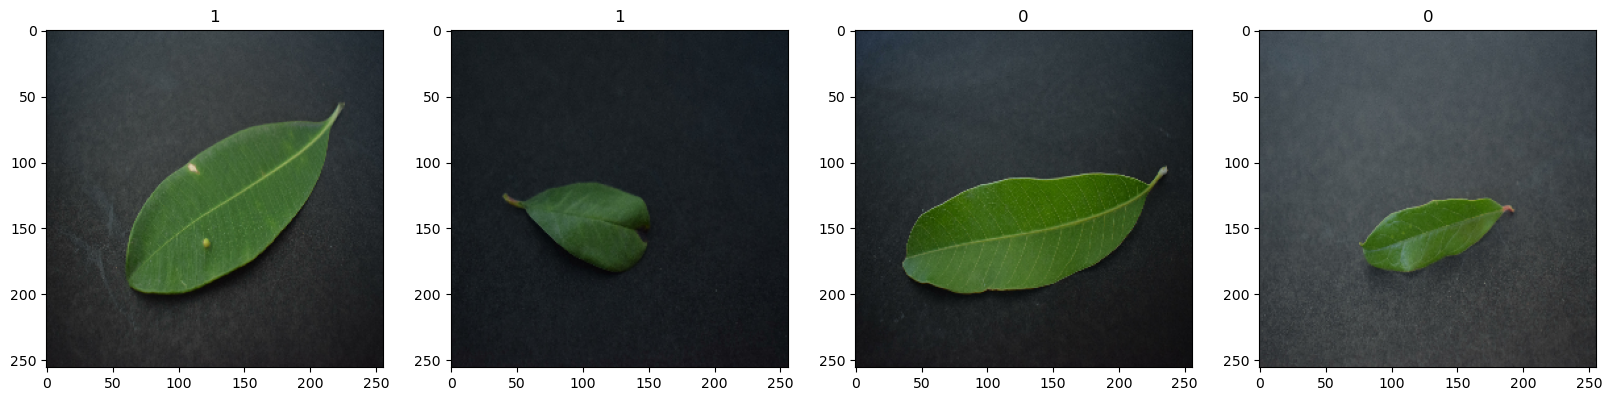

In [15]:
# for loop - looping through the images and classifying them as healthy = 0 and unhealthy = 1
#shows the classifications 0=healthy, 1 = unhealthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3.0. Pre-Processing Data

## 3.1. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y)) #map - applies a particular transformation as data is being preprocessed by the data pipeline... x = images, y = target values

In [17]:
scaled_iterator=data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

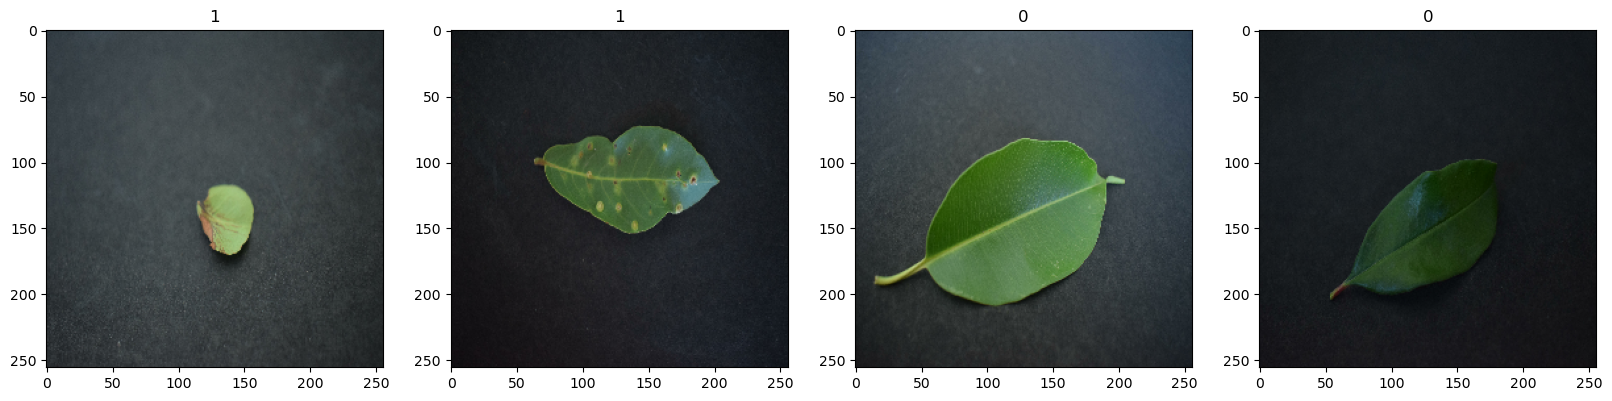

In [19]:
#CHECK IF IMAGES ARE LOADED AND SCALED
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    #shows the classifications healthy = 0 and unhealthy = 1

In [20]:
#CHECK FOR BATCH MAX AND MIN 0 - 1
#batch [0].min()
#batch [0].max()

## 3.2. Split Data

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
#Partitian Allocation
train_size = int(len(data)*.7) #training will be 70% of data
val_size = int(len(data)*.2) #20% for validation
test_size = int(len(data)*.1+1) #10% testing + 1 because the data is an uneven number

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=data_dir, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=train_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=data_dir, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=val_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=data_dir, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=test_size, shuffle=False)

Found 4502 images belonging to 2 classes.
Found 4502 images belonging to 2 classes.
Found 4502 images belonging to 2 classes.


# 4.0. Deep Learning Model

## 4.1. Build SVN + CNN Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [26]:
model = Sequential()

In [27]:
#Adding layers sequestially
#16 = Number of filters
#3,3 = Size of filter
#1 Stride (one pixel and then moves onto the next pixel)
#activitation that gets applied - relu activation - taking the output from the convolution layer and passing it through the relu function - preserve the positive values - allows us to take into account the non linear values 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) #condenses the data down

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu')) #fully connected layers

#Output layer
model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [28]:
model.compile('adam', loss='squared_hinge', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 4.2. Train

In [30]:
from tensorflow.keras.callbacks import TensorBoard

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val) #fit is the training function

Epoch 1/20
98/98 [==============================] - 418s 4s/step - loss: 1.1130 - accuracy: 0.5427 - val_loss: 1.0117 - val_accuracy: 0.4944
Epoch 2/20
98/98 [==============================] - 493s 5s/step - loss: 0.9682 - accuracy: 0.5246 - val_loss: 0.9768 - val_accuracy: 0.4799
Epoch 3/20
98/98 [==============================] - 378s 4s/step - loss: 0.8193 - accuracy: 0.6253 - val_loss: 0.8814 - val_accuracy: 0.5547
Epoch 4/20
98/98 [==============================] - 371s 4s/step - loss: 0.6742 - accuracy: 0.6786 - val_loss: 0.7907 - val_accuracy: 0.7132
Epoch 5/20
98/98 [==============================] - 375s 4s/step - loss: 0.5197 - accuracy: 0.7618 - val_loss: 0.6257 - val_accuracy: 0.7210
Epoch 6/20
98/98 [==============================] - 373s 4s/step - loss: 0.4200 - accuracy: 0.8029 - val_loss: 0.5424 - val_accuracy: 0.7701
Epoch 7/20
98/98 [==============================] - 376s 4s/step - loss: 0.3372 - accuracy: 0.8444 - val_loss: 0.5723 - val_accuracy: 0.7645
Epoch 8/20
98

## 4.3. Plot Performance

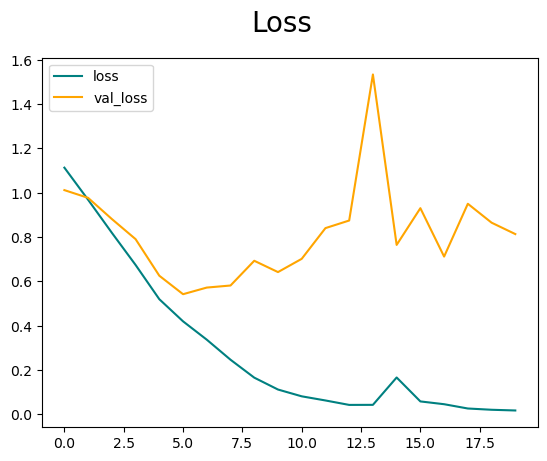

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

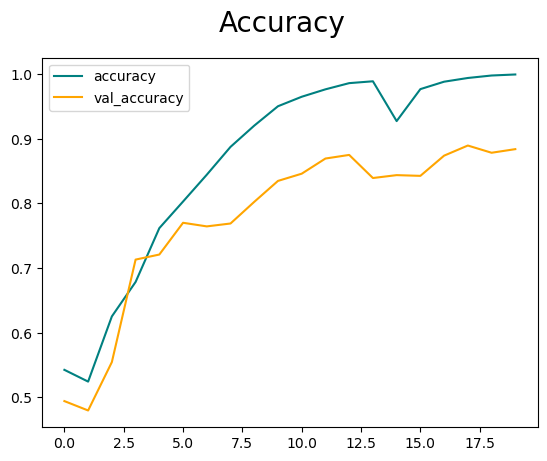

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 5.0 Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test_batches.fit_generator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

AttributeError: 'DirectoryIterator' object has no attribute 'fit_generator'

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

# 6.0 Test

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
img = cv2.imread('healthy_test.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Unhealthy')
else:
    print(f'Predicted class is Healthy')

# 7.0 Confusion Matrix

## 7.1 Prepare Data

In [ ]:
#Import necessary libraries
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
test_labels = []
test_imgs = []

In [ ]:
train_imgs, train_labels = train_batches.next()
test_imgs, test_labels = train_batches.next()

In [ ]:
for batch in train_batches.as_numpy_iterator(): 
    test_imgs, test_labels = train_batches.next()
    yhat = model.predict(test_imgs)
    pre.update_state(test_labels, yhat)
    re.update_state(test_labels, yhat)
    acc.update_state(test_labels, yhat)

In [ ]:
plotImages(test_imgs)
print(test_labels)

## 7.2 Predicting on the Test Data

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

# 8.0 Data Augmentation

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [ ]:
chosen_image = random.choice(os.listdir('data/unhealthy-vs-healthy/train/unhealthy'))

In [ ]:
image_path = 'data/unhealthy-vs-healthy/train/unhealthy' + chosen_image

In [ ]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plotImages(aug_images)

In [ ]:
aug_iter = gen.flow(image, save_to_dir='data/unhealthy-vs-healthy/train/unhealthy', save_prefix='aug-image-', save_format='jpeg')

# 9.0 Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','leafhealth.h5'))

In [ ]:
new_model = load_model('leafhealth.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))